# Data load and Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

# drive mounting
from google.colab import drive
drive.mount('/content/drive')

BASE_URL = '/content/drive/My Drive/ISS'
initial = []

Mounted at /content/drive


In [ ]:
# bengin training set 을 가져와 하나의 리스트로 합침
for i in range(0, 15):
  if (i<10):
      df = pd.read_csv(BASE_URL+"/network_benign_training_set/network_benign_training_set_0%d.csv"%(i), encoding='utf-8', error_bad_lines=False)
  else:
      df = pd.read_csv(BASE_URL+"/network_benign_training_set/network_benign_training_set_%d.csv"%(i), encoding='utf-8', error_bad_lines=False)
  df = df[df['ip.src'].notnull()] # ip.src 값이 있는 데이터들만 취급
  df = df[df['tcp.srcport'].notnull()] # tcp.srcport 값이 있는 데이터들만 취급
  initial.append(df)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (12,13,14,15,16,18,19,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 311515: expected 22 fields, saw 23\nSkipping line 313317: expected 22 fields, saw 23\n'
b'Skipping line 47484: expected 22 fields, saw 23\n'
b'Skipping line 122815: expected 22 fields, saw 27\n'
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (18,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell

In [ ]:
# malicious training set
mal_df = pd.read_csv(BASE_URL+"/network_malicious_training_set.csv", encoding='utf-8', error_bad_lines=False)
mal_df = mal_df[mal_df['ip.src'].notnull()] # ip.src 값이 있는 데이터들만 취급
mal_df = mal_df[mal_df['tcp.srcport'].notnull()] # tcp.srcport 값이 있는 데이터들만 취급

print(len(mal_df))

2089


In [ ]:
# 정상 dataset 에 대해 다섯 개의 컬럼을 기준으로 grouping
groupset=[]

for i in range(len(initial)):
  print(i)
  gb5 = initial[i].groupby(['_ws.col.Protocol','ip.src','ip.dst','tcp.seq','tcp.ack'])
  for key, value in gb5:
      value = np.asarray(value)
      groupset.append(value)
        
print(len(groupset))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
17861724


In [ ]:
# 악성 dataset 에 대해 다섯 개의 컬럼을 기준으로 grouping
mal_groupset=[]
mal_gb5 = mal_df.groupby(['_ws.col.Protocol','ip.src','ip.dst','tcp.seq','tcp.ack'])

for key, value in mal_gb5:
  value = np.asarray(value)
  mal_groupset.append(value)
    
print(len(mal_groupset)) 

312


# Feature for training

In [ ]:
# selected feature
# 1. 시간당 패킷개수 
#     : 시간당 얼마나 많은 요청을 보냈는지 확인하기 위해 (dos 공격 예상)
# 2. 같은 protocol, ip.src, ip.dst, tcp.seq, tcp.ack 에 대해 다른 tcp.srcport 가 몇개인지
#     : 같은 데이터를 다양한 포트로 계속해서 전달하는 확인하기 위해

In [ ]:
# 1. 시간당 패킷개수
def duration(stream): # 스트림 통신시간 (스트림 마지막시간 - 스트림 시작시간) 
  if (len(stream) == 1): # 패킷이 하나인 경우
      return -1
  time = stream[0] # '_ws.col.UTCtime'
  return (max(pd.to_timedelta(time)).total_seconds() - min(pd.to_timedelta(time)).total_seconds())
  
def packetNumPerTime(stream):
  if duration(stream) == 0: # 나눌 수 없는 경우
      return 0
  return len(stream) / duration(stream)

In [ ]:
# 2. 같은 protocol, ip.src, ip.dst, tcp.seq, tcp.ack 에 대해 다른 tcp.srcport 가 몇개인지
def packetWithDiffSrcport(stream):
    srcportNum = []
    for i in range(len(stream)):
        srcportNum.append(stream[4][i]) # tcp.srcport 
    return len(list(set(srcportNum))) # 중복제거

In [ ]:
# Feature 추출 - 정상
X = []
num = 0
for i in range(500000): # len(groupset) 즉 17861724개는 ram 초과 -> 50000, 1000000 등 데이터 줄여서 train
  print(i)
  df_t = pd.DataFrame(groupset[i])
  
  # function 계산 후 컬럼 assign
  df_t = df_t.assign(packetNumPerTime=packetNumPerTime(df_t))
  df_t = df_t.assign(packetWithDiffSrcport=packetWithDiffSrcport(df_t))
  
  # dataframe 변환 
  for j in range(len(df_t['packetNumPerTime'])):
      raw_data = {'packetNumPerTime': [df_t['packetNumPerTime'][j]],
              'packetWithDiffSrcport': [df_t['packetWithDiffSrcport'][j]]}
      data = pd.DataFrame((raw_data), index = [num])
      num += 1
      X.append(data)

In [ ]:
X_normal_data=np.asarray(X)
X_normal_data.shape

In [ ]:
Y=[]
for i in range(len(X)):
  Y.append(0) # 정상 label
print(len(Y))

In [ ]:
Y_normal_data=np.asarray(Y)
Y_normal_data.shape

In [ ]:
# Feature 추출 - 악성
X_a = []
num = 0
for i in range(len(mal_groupset)):
  df_t = pd.DataFrame(mal_groupset[i])
  
  # function 계산 후 컬럼 assign
  df_t = df_t.assign(packetNumPerTime=packetNumPerTime(df_t))
  df_t = df_t.assign(packetWithDiffSrcport=packetWithDiffSrcport(df_t))
  
  # dataframe 변환
  for j in range(len(df_t['packetNumPerTime'])):
    raw_data = {'packetNumPerTime': [df_t['packetNumPerTime'][j]],
            'packetWithDiffSrcport': [df_t['packetWithDiffSrcport'][j]]}
    data = pd.DataFrame((raw_data), index = [num])
    num += 1
    X_a.append(data)

In [ ]:
X_attack_data=np.asarray(X_a)
X_attack_data.shape

(2089, 1, 2)

In [ ]:
Y_a=[]
for i in range(len(X_a)):
  Y_a.append(1) # 악성 label
print(len(Y_a))

2089


In [ ]:
Y_attack_data=np.asarray(Y_a)
Y_attack_data.shape

(2089,)

In [ ]:
X_total = np.concatenate((X_normal_data, X_attack_data), axis=0)
Y_total = np.concatenate((Y_normal_data, Y_attack_data), axis=0)

In [ ]:
from sklearn.model_selection import train_test_split
# training, validation을 위한 training set split 과정
X_train, X_test, Y_train, Y_test = train_test_split(X_total, Y_total, test_size=0.3, shuffle=True, random_state=7171)

In [ ]:
X_train = np.squeeze(X_train, axis=1) # dimension squeeze
X_test = np.squeeze(X_test, axis=1) # dimension squeeze
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

# RandomForestClassifier

In [ ]:
# benign vs malicious : 이진분류
# RandomForestClassifier 이용
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [10, 50, 100, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [6,8,10,12]
    }

# grid search -> 최적 parameter 탐색
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv = 5)
CV_rfc.fit(X_train, Y_train)
print(CV_rfc.best_params_)

RandomForestClassifier(max_depth=12, n_estimators=50, random_state=42)

In [ ]:
# model = RandomForestClassifier(n_estimators=100)
# model.fit(X_train, Y_train)

model = CV_rfc # grid search 로 발견한 최적의 parameter를 갖는 모델

# model save 
import joblib 
joblib.dump(model, 'rf_model01.pkl')

print(model.score(X_train, Y_train))	# score값이 80~90%이면 모델링에 적합함
print(model.score(X_test, Y_test))

In [ ]:
# cross validation
from sklearn.model_selection import cross_val_score, LeaveOneOut

cv = LeaveOneOut()
scores = cross_val_score( model , X_train , Y_train , scoring = 'accuracy' , cv = cv , n_jobs = -1 )

In [ ]:
# print accuracy from cross validation
from numpy import mean, std
print( f'ACCURACY : {mean( scores ):.3f} ( {std( scores ):.3f} )' )

In [ ]:
from sklearn.tree import export_graphviz

estimator = model.estimators_[5]

# .dot 파일로 export
export_graphviz(estimator, out_file='tree.dot', 
                max_depth = 6, # 표현하고 싶은 최대 depth
                class_names=['benign', 'mal'], # class
                precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True, # 박스의 모양을 둥글게
               )

# 생성된 .dot 파일을 .png로 변환
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'decistion-tree.png', '-Gdpi=600'])

# jupyter notebook에서 .png 출력
from IPython.display import Image
Image(filename = 'decistion-tree.png')

# Candidate models and Visualization

Using random forest, N_estimators: 100
Accuracy: 0.9973072215422276
F_measure: [0.99860184 0.96363636]
Recall: [0.99936399 0.94489465]
Precision: [0.99784086 0.98313659]




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


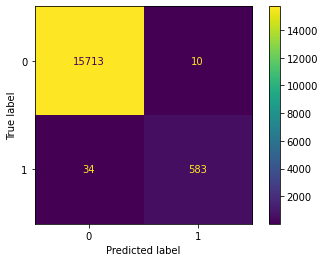

In [ ]:
# 모델의 정확도를 시각화
from sklearn.metrics import f1_score,recall_score,precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plot

# DT
def decisionTree(train_x,train_y,test_x,test_y): 
  print("Using Decision trees:")
  clf = DecisionTreeClassifier()
  clf.fit(train_x, train_y)
  predcted_y = clf.predict(test_x)
  accuracy = clf.score(test_x, test_y)
  print(f"Accuracy: {accuracy}")
  f_measure = f1_score(test_y, predcted_y, average=None, labels=[0, 1])
  print(f"F_measure: {f_measure}")
  recall = recall_score(test_y, predcted_y, average=None, labels=[0, 1])
  print(f"Recall: {recall}")
  precision = precision_score(test_y, predcted_y, average=None, labels=[0, 1])
  print(f"Precision: {precision}\n\n")
  plot_confusion_matrix(clf, test_x, test_y)
  plot.show()

# RF
def randomForest(clf,test_x,test_y,n_estimators=100): 
  print(f"Using random forest, N_estimators: {n_estimators}")
  # clf = RandomForestClassifier(n_estimators=n_estimators)
  # clf.fit(train_x, train_y)
  predcted_y = clf.predict(test_x)
  accuracy = clf.score(test_x, test_y)
  print(f"Accuracy: {accuracy}")
  f_measure = f1_score(test_y, predcted_y, average=None, labels=[0, 1])
  print(f"F_measure: {f_measure}")
  recall = recall_score(test_y, predcted_y, average=None, labels=[0, 1])
  print(f"Recall: {recall}")
  precision = precision_score(test_y, predcted_y, average=None, labels=[0, 1])
  print(f"Precision: {precision}\n\n")
  plot_confusion_matrix(clf, test_x, test_y)
  plot.show()

# KNN
def kNearestNeighbor(train_x,train_y,test_x,test_y,k=3):
  print(f"Using K Nearest Neighbour, K: {k}")
  clf = KNeighborsClassifier(n_neighbors=k)
  clf.fit(train_x, train_y)
  predcted_y = clf.predict(test_x)
  accuracy = clf.score(test_x, test_y)
  print(f"Accuracy: {accuracy}")
  f_measure = f1_score(test_y, predcted_y, average=None, labels=[0, 1])
  print(f"F_measure: {f_measure}")
  recall = recall_score(test_y, predcted_y, average=None, labels=[0, 1])
  print(f"Recall: {recall}")
  precision = precision_score(test_y, predcted_y, average=None, labels=[0, 1])
  print(f"Precision: {precision}\n\n")

# 이 중 사용한 것은 RF
randomForest(model, X_test, Y_test)

# Prediction for Test Dataset 

In [ ]:
#############
# test data #
#############

test_df = pd.read_csv(BASE_URL+"/network_test_dataset.csv", encoding='utf-8', error_bad_lines=False)
test_df.columns = ['_ws.col.UTCtime','_ws.col.Protocol','ip.src','ip.dst','tcp.srcport','tcp.dstport','tcp.len','tcp.seq','tcp.ack','udp.srcport','udp.dstport','udp.length','http.request.method','http.request.uri','http.user_agent','http.connection','http.host','http.response.code','http.server','http.content_type','http.content_length','http.cache_control']
test_df = test_df[test_df['ip.src'].notnull()] # ip.src 값이 있는 데이터들만 취급
test_df = test_df[test_df['tcp.srcport'].notnull()] # tcp.srcport 값이 있는 데이터들만 취급
print(len(test_df))

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 1000426: expected 22 fields, saw 23\n'
b'Skipping line 1279004: expected 22 fields, saw 23\n'
b'Skipping line 3023273: expected 22 fields, saw 27\n'
b'Skipping line 3074890: expected 22 fields, saw 27\n'
b'Skipping line 3460738: expected 22 fields, saw 23\n'


3172382


In [ ]:
# 시간순 정렬
test_df = test_df.sort_values(by=['_ws.col.UTCtime'], axis=0)
test_df.head()

_ws.col.UTCtime _ws.col.Protocol         ip.src         ip.dst  \
93912          12:20:38              TCP  192.168.10.50     172.16.0.1   
1461279        12:20:38              TCP     172.16.0.1  192.168.10.50   
1174538        12:20:38              FTP  192.168.10.50     172.16.0.1   
1667698        12:20:38              TCP  192.168.10.50     172.16.0.1   
777192         12:20:38              FTP     172.16.0.1  192.168.10.50   

         tcp.srcport  tcp.dstport  tcp.len  tcp.seq  tcp.ack  udp.srcport  \
93912           21.0      52280.0      0.0     55.0     37.0          NaN   
1461279      52278.0         21.0      0.0      0.0      0.0          NaN   
1174538         21.0      52262.0     22.0    167.0    112.0          NaN   
1667698         21.0      52262.0      0.0    190.0      0.0          NaN   
777192       52276.0         21.0     20.0     15.0     55.0          NaN   

         ...  http.request.method  http.request.uri http.user_agent  \
93912    ...                  NaN               NaN             NaN   
1461279  ...                  NaN               NaN             NaN   
1174538  ...                  NaN               NaN             NaN   
1667698  ...                  NaN               NaN             NaN   
777192   ...                  NaN               NaN             NaN   

        http.connection http.host http.response.code http.server  \
93912               NaN       NaN                NaN         NaN   
1461279             NaN       NaN                NaN         NaN   
1174538             NaN       NaN                NaN         NaN   
1667698             NaN       NaN                NaN         NaN   
777192              NaN       NaN                NaN         NaN   

         http.content_type http.content_length http.cache_control  
93912                  NaN                 NaN                NaN  
1461279                NaN                 NaN                NaN  
1174538                NaN                 NaN                NaN  
1667698                NaN                 NaN                NaN  
777192                 NaN                 NaN                NaN  

[5 rows x 22 columns]

In [ ]:
# test dataset을 다섯 개의 열로 grouping
test_groupset=[]
test_gb5 = test_df.groupby(['_ws.col.Protocol','ip.src','ip.dst','tcp.seq','tcp.ack'])

for key, value in test_gb5:
  value = np.asarray(value)
  test_groupset.append(value)
    
print(len(test_groupset)) 

1921188


In [ ]:
# Feature 추출 - test
X_test_final = []
num = 0
for i in range(len(test_groupset)): 
  print(i)
  df_t = pd.DataFrame(test_groupset[i])
  
  df_t = df_t.assign(packetNumPerTime=packetNumPerTime(df_t)) # 컬럼 assign
  df_t = df_t.assign(packetWithDiffSrcport=packetWithDiffSrcport(df_t))
  
  # dataframe으로 만들어줌
  for j in range(len(df_t['packetNumPerTime'])):
    raw_data = {'packetNumPerTime': [df_t['packetNumPerTime'][j]],
            'packetWithDiffSrcport': [df_t['packetWithDiffSrcport'][j]]}
    data = pd.DataFrame((raw_data), index = [num])
    num += 1
    X_test_final.append(data)

In [ ]:
X_test_final_data = np.asarray(X_test_final)
X_test_final_data = np.squeeze(X_test_final_data, axis=1) # dimension squeeze
print(X_test_final_data.shape)

(3172381, 2)


In [ ]:
# import joblib
# loaded_model = joblib.load('rf_model01.pkl')

predicted = model.predict(X_test_final_data) # test dataset 에 대한 예측결과
print(predicted)

[0 0 0 ... 0 0 0]


# Result

In [ ]:
# 악성이라고 예측한 값들에 대해 index print -> 이 인덱스로 5-tuple 값 뽑을 것
index_list = []
for i in range(len(X_test_final_data)):
  if predicted[i] == 1:
    index_list.append(i)
  
index_list = list(set(index_list))
print(index_list)

[3145735, 3145736, 3145737, 1572882, 1572883, 1572884, 1572885, 1572886, 1572887, 1048637, 1048638, 1048639, 1048640, 1048641, 1048642, 1048643, 1048644, 1048645, 1048646, 1048647, 1048648, 73, 74, 75, 76, 77, 78, 1048649, 1048650, 1048657, 1048651, 1048659, 1048660, 1048661, 1048662, 1048654, 1048655, 1048656, 1048658, 1048663, 1048664, 1048665, 1048666, 1048667, 1048672, 97, 98, 99, 100, 101, 102, 103, 1048673, 1048674, 1048675, 1048676, 2097281, 2097282, 2097283, 2097284, 1048718, 1048719, 2097296, 2097297, 2097298, 2097299, 2097300, 2097301, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 173, 174, 175, 177, 178, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 1048812, 240, 241, 242, 243,

In [ ]:
# 5-tuple 결과 다운로드 
final_res = []
# 원래 dataset에서 해당 index 를 찾아 append
for index in index_list:
  try:
    final_res.append(test_df.loc[index])
  except:
    pass

df_t = pd.DataFrame(final_res)
# 5-tuple 을 만들기 위해 필요없는 컬럼 제거
final_res_df = df_t.drop([df_t.columns[0],df_t.columns[6],df_t.columns[7],df_t.columns[8],df_t.columns[9],
                          df_t.columns[10],df_t.columns[11],df_t.columns[12],df_t.columns[13],
                          df_t.columns[14],df_t.columns[15],df_t.columns[16],df_t.columns[17],
                          df_t.columns[18],df_t.columns[19],df_t.columns[20],df_t.columns[21]], axis=1)

final_res_df.columns = ["Protocol", "Source IP", "Destination IP", "Source Port", "Destination Port"]

final_res_df = final_res_df.sort_values(by=['Source IP', 'Destination IP'], axis=0) # ip.src, ip.dst 기준으로 정렬

print(len(final_res))
print(final_res_df)
final_res_df.to_csv('final_result_team9.csv', sep=',', index = False) # csv 파일로 변환

169099
        Protocol        Source IP Destination IP  Source Port  \
1118572      TCP        1.9.56.32  192.168.10.15         80.0   
1087480      TCP  101.102.235.200   192.168.10.5        443.0   
1211460      TCP  101.102.235.200   192.168.10.5        443.0   
45549        TCP  101.254.102.143  192.168.10.19        443.0   
2742890  TLSv1.2  101.254.102.143  192.168.10.19        443.0   
...          ...              ...            ...          ...   
3140411      TCP    99.192.248.32   192.168.10.5         80.0   
2620357      TCP    99.192.248.32   192.168.10.5         80.0   
524072       TCP    99.192.248.32   192.168.10.5         80.0   
2627093      TCP    99.193.229.25  192.168.10.17        443.0   
2898205      TCP    99.193.229.25  192.168.10.17        443.0   

         Destination Port  
1118572           51877.0  
1087480           64091.0  
1211460           64090.0  
45549             34548.0  
2742890           34548.0  
...                   ...  
3140411         